# MTVRP: Multi-task VRP environment


This environment can handle _any_ of the following variants:


| VRP Variant | Capacity (C) | Open Route (O) | Backhaul (B) | Duration Limit (L) | Time Window (TW) |
|-------------|--------------|----------------|--------------|--------------------|------------------|
| CVRP        | ✔            |                |              |                    |                  |
| OVRP        | ✔            | ✔              |              |                    |                  |
| VRPB        | ✔            |                | ✔            |                    |                  |
| VRPL        | ✔            |                |              | ✔                  |                  |
| VRPTW       | ✔            |                |              |                    | ✔                |
| OVRPTW      | ✔            | ✔              |              |                    | ✔                |
| OVRPB       | ✔            | ✔              | ✔            |                    |                  |
| OVRPL       | ✔            | ✔              |              | ✔                  |                  |
| VRPBL       | ✔            |                | ✔            | ✔                  |                  |
| VRPBTW      | ✔            |                | ✔            |                    | ✔                |
| VRPLTW      | ✔            |                |              | ✔                  | ✔                |
| OVRPBL      | ✔            | ✔              | ✔            | ✔                  |                  |
| OVRPBTW     | ✔            | ✔              | ✔            |                    | ✔                |
| OVRPLTW     | ✔            | ✔              |              | ✔                  | ✔                |
| VRPBLTW     | ✔            |                | ✔            | ✔                  | ✔                |
| OVRPBLTW    | ✔            | ✔              | ✔            | ✔                  | ✔                |


It is fully batched, meaning that _different variants can be in the same batch_ too!


In [7]:
%load_ext autoreload
%autoreload 2

from rl4co.envs.routing.mtvrp.env import MTVRPEnv
from rl4co.envs.routing.mtvrp.generator import MTVRPGenerator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's now generate some variants! By default, we can generate all variants with the `variants_preset` variable

In [8]:
# Single feat: generate a distribution of single-featured environments
generator = MTVRPGenerator(num_loc=50, variant_preset="all")
env = MTVRPEnv(generator, check_solution=False)

td_data = env.generator(8)
env.get_variant_names(td_data)

['CVRP', 'VRPBL', 'OVRPBTW', 'VRPBTW', 'OVRPTW', 'OVRP', 'OVRPB', 'VRPL']

In [9]:
# Here is the list of presets and their probabilities of being generated (fully customizable)
env.print_presets()

all: {'O': 0.5, 'TW': 0.5, 'L': 0.5, 'B': 0.5}
single_feat: {'O': 0.5, 'TW': 0.5, 'L': 0.5, 'B': 0.5}
cvrp: {'O': 0.0, 'TW': 0.0, 'L': 0.0, 'B': 0.0}
ovrp: {'O': 1.0, 'TW': 0.0, 'L': 0.0, 'B': 0.0}
vrpb: {'O': 0.0, 'TW': 0.0, 'L': 0.0, 'B': 1.0}
vrpl: {'O': 0.0, 'TW': 0.0, 'L': 1.0, 'B': 0.0}
vrptw: {'O': 0.0, 'TW': 1.0, 'L': 0.0, 'B': 0.0}
ovrptw: {'O': 1.0, 'TW': 1.0, 'L': 0.0, 'B': 0.0}
ovrpb: {'O': 1.0, 'TW': 0.0, 'L': 0.0, 'B': 1.0}
ovrpl: {'O': 1.0, 'TW': 0.0, 'L': 1.0, 'B': 0.0}
vrpbl: {'O': 0.0, 'TW': 0.0, 'L': 1.0, 'B': 1.0}
vrpbtw: {'O': 0.0, 'TW': 1.0, 'L': 0.0, 'B': 1.0}
vrpltw: {'O': 0.0, 'TW': 1.0, 'L': 1.0, 'B': 0.0}
ovrpbl: {'O': 1.0, 'TW': 0.0, 'L': 1.0, 'B': 1.0}
ovrpbtw: {'O': 1.0, 'TW': 1.0, 'L': 0.0, 'B': 1.0}
ovrpltw: {'O': 1.0, 'TW': 1.0, 'L': 1.0, 'B': 0.0}
vrpbltw: {'O': 0.0, 'TW': 1.0, 'L': 1.0, 'B': 1.0}
ovrpbltw: {'O': 1.0, 'TW': 1.0, 'L': 1.0, 'B': 1.0}


We can change the preset to generate some specific variant, for instance the VRPB

In [10]:
# Change generator
generator = MTVRPGenerator(num_loc=50, variant_preset="vrpb")
env.generator = generator
td_data = env.generator(8)
env.get_variant_names(td_data)

vrpb selected. Will not use feature combination!


['VRPB', 'VRPB', 'VRPB', 'VRPB', 'VRPB', 'VRPB', 'VRPB', 'VRPB']

## Greedy rollout and plot

In [11]:
import torch
from rl4co.utils.ops import gather_by_index


# Simple heuristics (nearest neighbor + capacity check)
def greedy_policy(td):
    """Select closest available action"""
    available_actions = td["action_mask"]
    # distances
    curr_node = td["current_node"]
    loc_cur = gather_by_index(td["locs"], curr_node)
    distances_next = torch.cdist(loc_cur[:, None, :], td["locs"], p=2.0).squeeze(1)

    distances_next[~available_actions.bool()] = float("inf")
    # do not select depot if some capacity is left
    distances_next[:, 0] = float("inf") * (
        td["used_capacity_linehaul"] < td["vehicle_capacity"]
    ).float().squeeze(-1)

    # # if sum of available actions is 0, select depot
    # distances_next[available_actions.sum(-1) == 0, 0] = 0
    action = torch.argmin(distances_next, dim=-1)
    td.set("action", action)
    return td


def rollout(env, td, policy=greedy_policy, max_steps: int = None):
    """Helper function to rollout a policy. Currently, TorchRL does not allow to step
    over envs when done with `env.rollout()`. We need this because for environments that complete at different steps.
    """

    max_steps = float("inf") if max_steps is None else max_steps
    actions = []
    steps = 0

    while not td["done"].all():
        td = policy(td)
        actions.append(td["action"])
        td = env.step(td)["next"]
        steps += 1
        if steps > max_steps:
            print("Max steps reached")
            break
    return torch.stack(actions, dim=1)

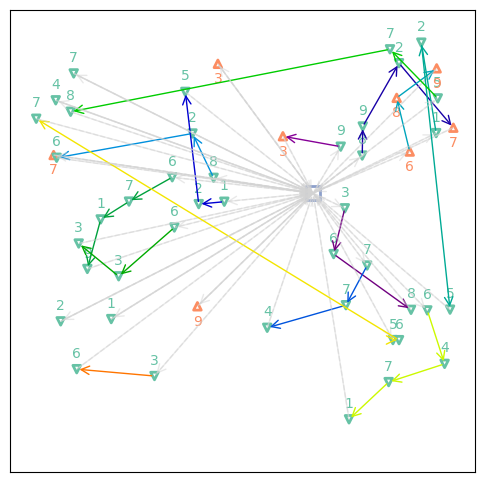

Cost:  14.162952423095703
Problem:  OVRPBTW


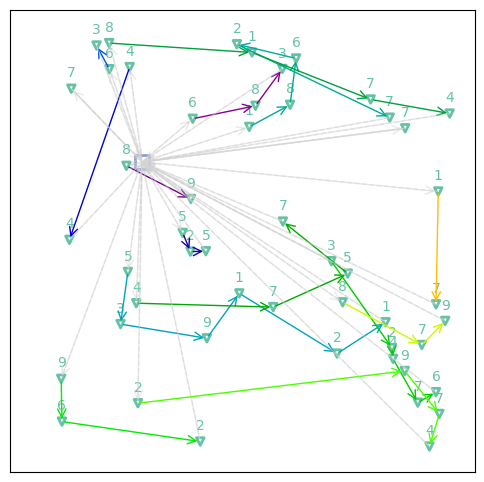

Cost:  21.007558822631836
Problem:  VRPTW


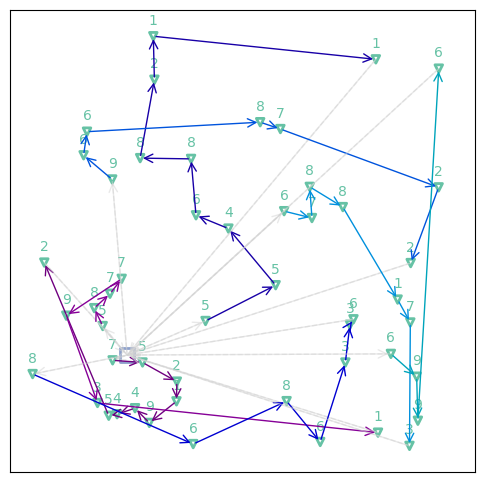

Cost:  14.564696311950684
Problem:  CVRP


In [12]:
# NOTE: if we don't select ovrpbltw, the below does not work and there is still some
# minor bug in either masking or variant subselection

generator = MTVRPGenerator(num_loc=50, variant_preset="all")
env.generator = generator
td_data = env.generator(3)
variant_names = env.get_variant_names(td_data)

td = env.reset(td_data)

actions = rollout(env, td.clone(), greedy_policy)
rewards = env.get_reward(td, actions)

for idx in [0, 1, 2]:
    env.render(td[idx], actions[idx])
    print("Cost: ", - rewards[idx].item())
    print("Problem: ", variant_names[idx])


## Train MVMoE on Multiple Problems

In [ ]:
from rl4co.utils.trainer import RL4COTrainer
from rl4co.models.zoo import MVMoE_POMO

device_id = 0
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")
generator = MTVRPGenerator(num_loc=50, variant_preset="single_feat")
env = MTVRPEnv(generator, check_solution=False)

In [ ]:
moe_kwargs = {"encoder": {"hidden_act": "ReLU", "num_experts": 4, "k": 2, "noisy_gating": True},
              "decoder": {"light_version": False, "num_experts": 4, "k": 2, "noisy_gating": True}}
model = MVMoE_POMO(
    env,
    moe_kwargs=moe_kwargs,
    batch_size=128,
    train_data_size=10000,  # each epoch,
    val_batch_size=100,
    val_data_size=1000,
    optimizer="Adam",
    optimizer_kwargs={"lr": 1e-4, "weight_decay": 1e-6},
    lr_scheduler="MultiStepLR",
    lr_scheduler_kwargs={"milestones": [451, ], "gamma": 0.1},
)

trainer = RL4COTrainer(
        max_epochs=3,
        accelerator="gpu",
        devices=[device_id],
        logger=None
    )

trainer.fit(model)

In [ ]:
# Greedy rollouts over trained model (same states as previous plot)
policy = model.policy.to(device)
out = policy(td.to(device).clone(), phase="test", decode_type="greedy", return_actions=True)
actions_mvmoe = out['actions'].cpu().detach()

for idx in [0, 1, 2]:
    env.render(td[idx], actions_mvmoe[idx])
    print("Cost: ", -out['reward'][idx].item())
    print("Problem: ", variant_names[idx])